In [1]:
import gym
import gym_example
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

## Checking that everything works

In [2]:
env = gym.make("adversarial-v1")

In [3]:
def visualize(state):
    fig = plt.imshow(state, cmap=plt.get_cmap('Accent'))
    # values
    values = np.array([0, 1, 2, 3])
    #items
    items = ['Arena', 'Agent', 'Goal', 'Wall']
    # colormap used by imshow
    colors = [fig.cmap(fig.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=items[i]) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    plt.grid(False)
    plt.show()

In [4]:
def run_one_episode(env, verbose=False):
    env.reset()
    sum_reward = 0

    for i in range(env.MAX_STEPS+1):
        action = env.action_space.sample()
        if verbose:
            print("action:", action)
        state, reward, done, info = env.step(action)
        sum_reward += reward

        if verbose:
            env.render()

        if done:
            if verbose:
                print("done @ step {}".format(i))
            break

    if verbose:
        print("cumulative reward", sum_reward)

    return sum_reward

Sum reward:  -10


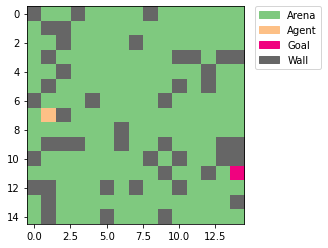

In [5]:
env = gym.make("adversarial-v1")
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

#visualize(env.state) --> if adversarial_v0

visualize(env.image_space) 

In [6]:
env = gym.make("adversarial-v1")
env.step(0)
env.step(0)

({'image': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [7]:
history = []

for _ in range(10):
    sum_reward = run_one_episode(env, verbose=False)
    history.append(sum_reward)

avg_sum_reward = sum(history) / len(history)
print("\nbaseline cumulative reward: {:6.2}".format(avg_sum_reward))


baseline cumulative reward: -1e+01


In [8]:
history

[-10, -10, -10, -10, -10, -10, -10, -10, -10, -10]

## Train

Initialize the directory in which to save checkpoints (i.e., serialize a policy to disk) as a subdirectory ./tmp/exa and also the directory in which to write the logs which Ray expects to be at ~/ray_results/ by default:

In [9]:
import os
import shutil

chkpt_root = "tmp/exa"

shutil.rmtree(chkpt_root, ignore_errors=True, onerror=None)
ray_results = "{}/ray_results/".format(os.getenv("HOME"))
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

We’ll start Ray running in local mode, i.e., not running on a remote cluster:

In [10]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

2021-03-29 17:16:38,845	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.1.48',
 'raylet_ip_address': '192.168.1.48',
 'redis_address': '192.168.1.48:24330',
 'object_store_address': '/tmp/ray/session_2021-03-29_17-16-38_219559_12194/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-29_17-16-38_219559_12194/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-03-29_17-16-38_219559_12194',
 'metrics_export_port': 49456,
 'node_id': '509f22d0368e8a3f1b0951facf023aab77b17b6c3975488f1bfb26d8'}

Register our environment

In [11]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v1 import Adversarial_v1

select_env = "adversarial-v1"
register_env(select_env, lambda config: Adversarial_v1())

Next we’ll configure the environment to use proximal policy optimization (PPO) and create an agent to train using RLlib:

In [12]:
import ray.rllib.agents.ppo as ppo

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

Instructions for updating:
non-resource variables are not supported in the long term


2021-03-29 17:16:44,763	INFO trainer.py:616 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-03-29 17:16:44,763	INFO trainer.py:643 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-03-29 17:16:44,818	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2021-03-29 17:16:46,010	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-03-29 17:16:46,956	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-03-29 17:16:49,546	WARNING util.py:47 -- Install gputil for GPU system monitoring.


In [13]:
ppo.DEFAULT_CONFIG

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 4000,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'num_framestacks': 'auto',
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_actio

For each iteration, we call result = agent.train() to run the episodes, and then call chkpt_file = agent.save(chkpt_root) to save a checkpoint of the latest policy. Then we print metrics that show how well the learning has progressed. The resulting output should look close to the following:

In [15]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f} saved {}"
n_iter = 100
for n in range(n_iter):
    result = agent.train()
    chkpt_file = agent.save(chkpt_root)
    print(status.format(
            n + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"],
            chkpt_file
            ))

 1 reward -10.00/ -3.40/100.00 len 53.00 saved tmp/exa/checkpoint_3/checkpoint-3
 2 reward -10.00/ -4.50/100.00 len 53.00 saved tmp/exa/checkpoint_4/checkpoint-4
 3 reward -10.00/ -3.40/100.00 len 53.00 saved tmp/exa/checkpoint_5/checkpoint-5
 4 reward -10.00/ -5.60/100.00 len 53.00 saved tmp/exa/checkpoint_6/checkpoint-6
 5 reward -10.00/ -8.90/100.00 len 53.00 saved tmp/exa/checkpoint_7/checkpoint-7
 6 reward -10.00/ -8.90/100.00 len 53.00 saved tmp/exa/checkpoint_8/checkpoint-8
 7 reward -10.00/ -6.70/100.00 len 53.00 saved tmp/exa/checkpoint_9/checkpoint-9
 8 reward -10.00/ -4.50/100.00 len 53.00 saved tmp/exa/checkpoint_10/checkpoint-10
 9 reward -10.00/ -3.40/100.00 len 53.00 saved tmp/exa/checkpoint_11/checkpoint-11
10 reward -10.00/ -5.60/100.00 len 53.00 saved tmp/exa/checkpoint_12/checkpoint-12
11 reward -10.00/ -6.70/100.00 len 53.00 saved tmp/exa/checkpoint_13/checkpoint-13
12 reward -10.00/ -6.70/100.00 len 53.00 saved tmp/exa/checkpoint_14/checkpoint-14
13 reward -10.00/ 

RayTaskError: [36mray::RolloutWorker.par_iter_next()[39m (pid=12194, ip=192.168.1.48)
  File "python/ray/_raylet.pyx", line 432, in ray._raylet.execute_task.function_executor
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/util/iter.py", line 1152, in par_iter_next
    return next(self.local_it)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 327, in gen_rollouts
    yield self.sample()
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 662, in sample
    batches = [self.input_reader.next()]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 95, in next
    batches = [self.get_data()]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 224, in get_data
    item = next(self.rollout_provider)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 656, in _env_runner
    tf_sess=tf_sess,
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 1344, in _do_policy_eval_w_trajectory_view_api
    episodes=[active_episodes[t.env_id] for t in eval_data])
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/policy/tf_policy.py", line 367, in compute_actions_from_input_dict
    fetched = builder.get(to_fetch)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/utils/tf_run_builder.py", line 44, in get
    self.feed_dict, os.environ.get("TF_TIMELINE_DIR"))
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/utils/tf_run_builder.py", line 89, in run_timeline
    fetches = sess.run(ops, feed_dict=feed_dict)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 956, in run
    run_metadata_ptr)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1152, in _run
    not subfeed_t.get_shape().is_compatible_with(np_val.shape)):
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_shape.py", line 1055, in is_compatible_with
    def is_compatible_with(self, other):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

[36mray::RolloutWorker.par_iter_next()[39m (pid=12194, ip=192.168.1.48)
  File "python/ray/_raylet.pyx", line 473, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 497, in ray._raylet.execute_task
ray.exceptions.TaskCancelledError: Task: TaskID(ffffffffffffffffffffffffffffffffffffffff01000000) was cancelled